In [ ]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET
from PIL import Image

from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import torch
import uuid



# Train License Plate Object Detection Model

## Part 1: Prepare YOLO dataset
- This stage is to create the dataset for the YOLO model
- then we will split the dataset into train and test
- then training the model
- then testing the model
- After that we will use the model to detect the objects in the images

In [ ]:
os.getcwd()

'D:\\Seneca\\CVI\\WS\\Final_project\\Preprocessing'

In [ ]:
# load data
kaggel_path = os.path.join(os.getcwd(), 'data/car_plate_datasets')
# get all images 
image_files_path = [os.path.join(kaggel_path,'images', file) for file in os.listdir(os.path.join(kaggel_path,'images'))]
# get all annotations
annotation_files_path = [os.path.join(kaggel_path,'annotations', file) for file in os.listdir(os.path.join(kaggel_path,'annotations'))]

In [ ]:
image_files_path[:5]

['D:\\Seneca\\CVI\\WS\\Final_project\\Preprocessing\\data/car_plate_datasets\\images\\Cars0.png',
 'D:\\Seneca\\CVI\\WS\\Final_project\\Preprocessing\\data/car_plate_datasets\\images\\Cars1.png',
 'D:\\Seneca\\CVI\\WS\\Final_project\\Preprocessing\\data/car_plate_datasets\\images\\Cars10.png',
 'D:\\Seneca\\CVI\\WS\\Final_project\\Preprocessing\\data/car_plate_datasets\\images\\Cars100.png',
 'D:\\Seneca\\CVI\\WS\\Final_project\\Preprocessing\\data/car_plate_datasets\\images\\Cars101.png']

In [ ]:
annotation_files_path[:5]

['D:\\Seneca\\CVI\\WS\\Final_project\\Preprocessing\\data/car_plate_datasets\\annotations\\Cars0.xml',
 'D:\\Seneca\\CVI\\WS\\Final_project\\Preprocessing\\data/car_plate_datasets\\annotations\\Cars1.xml',
 'D:\\Seneca\\CVI\\WS\\Final_project\\Preprocessing\\data/car_plate_datasets\\annotations\\Cars10.xml',
 'D:\\Seneca\\CVI\\WS\\Final_project\\Preprocessing\\data/car_plate_datasets\\annotations\\Cars100.xml',
 'D:\\Seneca\\CVI\\WS\\Final_project\\Preprocessing\\data/car_plate_datasets\\annotations\\Cars101.xml']

In [ ]:
# ==================================================================================
# === EXTRACT DATA FROM ANNOTATION FILES into Pandas DataFrame ======================
''' annotation file example
<annotation>
    <folder>images</folder>
    <filename>Cars0.png</filename>
    <size>
        <width>500</width>
        <height>268</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>licence</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>226</xmin>
            <ymin>125</ymin>
            <xmax>419</xmax>
            <ymax>173</ymax>
        </bndbox>
    </object>
</annotation>

'''


#=== STEP1: PARSE XML FILE TO DATAFRAME ===========================================
# This function will parse the XML file from Kaggle dataset and convert it to a DataFrame with the following columns: filename, xmin, ymin, xmax, ymax, width, height 
def parse_xml_file_to_dataframe(file_path):
    """
    Parse the XML file and convert it to a DataFrame.   
    :param file_path (str): Path to the XML file.
    :return: new DataFrame with columns: filename, xmin, ymin, xmax, ymax, width, height containing the label in int, bounding box coordinates and image size.
    """
    
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Extract global information
    filename = root.find("filename").text  # Extract filename at the root level
    
    # get Width and Height of image from size tag
    width = int(root.find("size/width").text)
    height = int(root.find("size/height").text)

    # Extract object-specific information
    data = []
    
    # Iterate over all objects in the 1 XML file => create 1 row in DataFrame for each object
    # if there are multiple objects in 1 image, there will be multiple rows in the DataFrame
    for obj in root.findall("object"):
        # Extract bounding box coordinates
        """
        <object>
            <name>licence</name>
            <pose>Unspecified</pose>
            <truncated>0</truncated>
            <occluded>0</occluded>
            <difficult>0</difficult>
            <bndbox>
                <xmin>226</xmin>
                <ymin>125</ymin>
                <xmax>419</xmax>
                <ymax>173</ymax>
            </bndbox>
        </object>
        """
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)

        # Append data to list as a single row
        data.append([filename, xmin, ymin, xmax, ymax, width, height])

    # Define the columns for the DataFrame
    columns = ["filename", "xmin", "ymin", "xmax", "ymax", "width", "height"]
    
    return pd.DataFrame(data, columns=columns)

# Create an empty DataFrame to store the parsed data with the following columns: filename, xmin, ymin, xmax, ymax, width, height
df_annotation = pd.DataFrame(columns=["filename", "xmin", "ymin", "xmax", "ymax", "width", "height"])

# Loop through all annotation files and concatenate the results to df_annotation
for file in annotation_files_path:
    df_annotation = pd.concat([df_annotation, parse_xml_file_to_dataframe(file)], axis=0)

df_annotation.reset_index(drop=True, inplace=True)
print(df_annotation.head())

      filename xmin ymin xmax ymax width height
0    Cars0.png  226  125  419  173   500    268
1    Cars1.png  134  128  262  160   400    248
2   Cars10.png  140    5  303  148   400    225
3  Cars100.png  175  114  214  131   400    267
4  Cars101.png  167  202  240  220   400    300


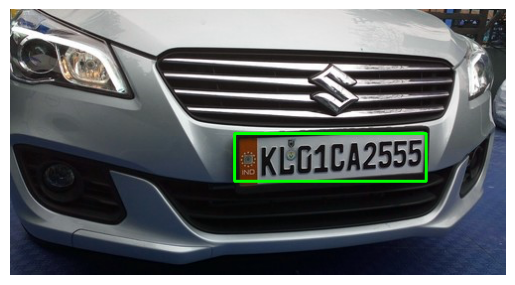

In [ ]:
# Example for 1st image 
image = cv2.imread(image_files_path[0])
xmin, ymin, xmax, ymax = df_annotation.iloc[0, 1:5]  
cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
plt.imshow(image)
plt.axis("off")
plt.show()

In [ ]:
# ==================================================================================
# === STEP2: CREATE YOLO Data Folder for TRAIN - VALIDATION - TEST =================
yolo_path_data = os.path.join(os.getcwd(), 'data/yolo_car_plate_convert/')

#split train, input, val data for yolo 
df_train, df_val = train_test_split(df_annotation, test_size=0.2, random_state=42)

# Function that create Yolo Data with the following structure:
# /yolo_path/data_type/images
# /yolo_path/data_type/labels
def create_yolo_folder(dataset_type, yolo_path, dataframe):
    
    # Check if fiolder exists, if not create it else remove it and create a new one
    if os.path.exists(os.path.join(yolo_path, dataset_type)):
        # if directory exists, remove it and create a new one
        shutil.rmtree(os.path.join(yolo_path, dataset_type)) 
    # create folder for images and labels 
    os.makedirs(os.path.join(yolo_path, dataset_type, 'images'))
    os.makedirs(os.path.join(yolo_path, dataset_type, 'labels'))
    
    # Copy images to yolo folder and create labels
    for index, row in dataframe.iterrows():
        # Copy images
        image_name = row['filename']
        shutil.copy(os.path.join(kaggel_path, 'images', image_name), os.path.join(yolo_path, dataset_type, 'images', image_name))
        # Create labels
    
    
    # Create LABELS FILE in /yolo_path/dataset_type/labels 
    for i in dataframe['filename'].unique(): 
        # Create labels file
        with open(os.path.join(yolo_path, dataset_type, 'labels', i.split('.')[0] + '.txt'), 'w') as f:
            for index, row in dataframe[dataframe['filename'] == i].iterrows():
                # YOLO format: <object-class> <x> <y> <width> <height>
                # with x_center = x / width, y_center = y / height, width = width / width, height = height / height Recalculate the bounding box coordinates for the YOLO format
                class_id = 0
                img_width = row["width"]
                img_height = row["height"]
                x_center = ((row["xmin"] + row["xmax"]) / 2) / img_width
                y_center = ((row["ymin"] + row["ymax"]) / 2) / img_height
                box_width = (row["xmax"] - row["xmin"]) / img_width
                box_height = (row["ymax"] - row["ymin"]) / img_height
                
                f.write(f"{class_id} {x_center} {y_center} {box_width} {box_height}\n")

# Create YOLO dataset for train and val
# /yolo_path/train/images OR /labels
# /yolo_path/val/images OR /labels
create_yolo_folder('train', yolo_path_data, df_train)
create_yolo_folder('val', yolo_path_data, df_val)
    

In [ ]:
# Create DATA.YAML CONFIGURATION FILE for YOLO 
data_yaml = f"""
# root dir
path: {yolo_path_data}

# Directories
train: train/images
val: val/images

# number of class
nc: 1

# class name
names: ['licence_plate']

"""
# Save the data.yaml file
with open(os.path.join(yolo_path_data,"datasets.yaml"),"w") as file:
    file.write(data_yaml)


In [ ]:
# check GPU enable for training 

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


2.5.1+cu124
True
NVIDIA GeForce RTX 4060 Laptop GPU


In [ ]:
# === STEP3: TRAIN YOLO MODEL =====================================================
# Load the YOLO model
model = YOLO('yolo11n.pt')


In [ ]:
# delete folder runs/train/ if exist 
if os.path.exists(r'data/yolo_car_plate_convert/runs/train/'):
    shutil.rmtree(r'data/yolo_car_plate_convert/runs/train/')

# === TRAIN MODEL ===============================================================
# train model using the dataset with 
# data: path to the data.yaml file
# epochs: number of epochs to train the model
# batch: batch size for training for example 16 mean 16 images will be processed in 1 batch for training
# imgsz: image size for training (Maximun size is 640)
# device: GPU device to use for training
# cache: cache images for faster training
# project: directory to save the training results
# name: name of the model
# verbose: print the training progress
model.train(data='data/yolo_car_plate_convert/datasets.yaml', 
            epochs=100, 
            batch=16, 
            imgsz=320,
            device = 0,
            cache=True,
            project ='data/yolo_car_plate_convert/runs/train',
            name='license_plate', verbose=False
            )

New https://pypi.org/project/ultralytics/8.3.38 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.36  Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=data/yolo_car_plate_convert/datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=0, workers=8, project=data/yolo_car_plate_convert/runs/train, name=license_plate, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=

train: Scanning D:\Seneca\CVI\WS\Final_project\Preprocessing\data\yolo_car_plate_convert\train\labels... 350 images, 0 backgrounds, 0 corrupt: 100%|██████████| 350/350 [00:00<00:00, 509.86it/s]

train: New cache created: D:\Seneca\CVI\WS\Final_project\Preprocessing\data\yolo_car_plate_convert\train\labels.cache


WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.1GB RAM): 100%|██████████| 350/350 [00:00<00:00, 1186.79it/s]
val: Scanning D:\Seneca\CVI\WS\Final_project\Preprocessing\data\yolo_car_plate_convert\val\labels... 93 images, 0 backgrounds, 0 corrupt: 100%|██████████| 93/93 [00:00<00:00, 427.28it/s]

val: New cache created: D:\Seneca\CVI\WS\Final_project\Preprocessing\data\yolo_car_plate_convert\val\labels.cache


WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 93/93 [00:00<00:00, 1177.93it/s]


Plotting labels to data\yolo_car_plate_convert\runs\train\license_plate\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 320 train, 320 val
Using 8 dataloader workers
Logging results to data\yolo_car_plate_convert\runs\train\license_plate
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.742G      1.702      3.184       1.29         25        320: 100%|██████████| 22/22 [00:06<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]

                   all         93         95    0.00312      0.811      0.126     0.0576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.726G      1.599      1.757      1.185         24        320: 100%|██████████| 22/22 [00:03<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.67it/s]

                   all         93         95     0.0032      0.863      0.117     0.0499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.724G      1.545      1.493      1.198         30        320: 100%|██████████| 22/22 [00:03<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.08it/s]

                   all         93         95     0.0144      0.705       0.39      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.713G      1.532      1.368      1.178         31        320: 100%|██████████| 22/22 [00:03<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]

                   all         93         95      0.302      0.274      0.182     0.0799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.711G      1.507      1.277      1.207         26        320: 100%|██████████| 22/22 [00:03<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.32it/s]

                   all         93         95       0.48      0.453      0.373      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.724G      1.483      1.238      1.181         20        320: 100%|██████████| 22/22 [00:03<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

                   all         93         95      0.632      0.568      0.553      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.713G      1.474        1.2      1.193         26        320: 100%|██████████| 22/22 [00:02<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.84it/s]

                   all         93         95      0.503      0.543      0.455      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.726G      1.467      1.112      1.187         30        320: 100%|██████████| 22/22 [00:01<00:00, 14.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.60it/s]

                   all         93         95      0.714      0.631      0.672      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.711G      1.389      1.081      1.156         35        320: 100%|██████████| 22/22 [00:01<00:00, 15.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.33it/s]

                   all         93         95      0.779      0.663      0.696      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.724G      1.415      1.013       1.15         24        320: 100%|██████████| 22/22 [00:01<00:00, 14.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.79it/s]

                   all         93         95      0.742      0.696      0.708      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.713G      1.388       1.01      1.127         33        320: 100%|██████████| 22/22 [00:01<00:00, 15.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.05it/s]

                   all         93         95      0.737      0.695      0.719      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.724G      1.321     0.9842      1.094         29        320: 100%|██████████| 22/22 [00:01<00:00, 15.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.35it/s]

                   all         93         95      0.699      0.663      0.692      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.711G      1.376      0.985       1.13         29        320: 100%|██████████| 22/22 [00:01<00:00, 14.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.72it/s]

                   all         93         95      0.772      0.711      0.767      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.726G       1.39     0.9581      1.123         31        320: 100%|██████████| 22/22 [00:01<00:00, 14.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.79it/s]

                   all         93         95      0.821      0.674      0.776      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.711G       1.33      0.915      1.114         30        320: 100%|██████████| 22/22 [00:01<00:00, 14.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.43it/s]

                   all         93         95      0.839      0.602      0.699      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.724G      1.329     0.9202      1.125         24        320: 100%|██████████| 22/22 [00:01<00:00, 14.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.88it/s]

                   all         93         95       0.83      0.568       0.67      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.711G      1.306     0.8919      1.104         31        320: 100%|██████████| 22/22 [00:01<00:00, 14.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.04it/s]

                   all         93         95      0.868      0.632      0.776      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.726G      1.297     0.8678      1.103         42        320: 100%|██████████| 22/22 [00:01<00:00, 14.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.72it/s]

                   all         93         95       0.77      0.777      0.754      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.711G      1.345     0.8732        1.1         26        320: 100%|██████████| 22/22 [00:01<00:00, 14.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.27it/s]

                   all         93         95      0.867      0.737      0.804      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.724G      1.299     0.8475      1.078         25        320: 100%|██████████| 22/22 [00:01<00:00, 14.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.35it/s]

                   all         93         95      0.836      0.779      0.825      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.711G      1.306     0.8171      1.089         28        320: 100%|██████████| 22/22 [00:01<00:00, 14.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.79it/s]

                   all         93         95      0.784      0.779      0.835       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.726G       1.23     0.8273      1.095         19        320: 100%|██████████| 22/22 [00:01<00:00, 14.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.21it/s]

                   all         93         95      0.746      0.726       0.79      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.711G      1.245     0.8251      1.069         26        320: 100%|██████████| 22/22 [00:01<00:00, 15.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.18it/s]

                   all         93         95      0.889      0.684      0.806      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.724G      1.272     0.8021      1.066         21        320: 100%|██████████| 22/22 [00:01<00:00, 13.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.51it/s]

                   all         93         95      0.788      0.783        0.8      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.711G      1.263     0.7905      1.079         28        320: 100%|██████████| 22/22 [00:01<00:00, 14.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.04it/s]

                   all         93         95      0.806      0.789      0.792       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.724G      1.284     0.7766      1.076         26        320: 100%|██████████| 22/22 [00:01<00:00, 14.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.94it/s]

                   all         93         95      0.762      0.821      0.741       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.711G      1.185     0.7631      1.065         29        320: 100%|██████████| 22/22 [00:01<00:00, 14.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.61it/s]

                   all         93         95      0.848      0.811      0.842      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.724G      1.205     0.7669      1.051         33        320: 100%|██████████| 22/22 [00:01<00:00, 14.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.77it/s]

                   all         93         95      0.846      0.808       0.82      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.711G      1.176     0.7447      1.048         23        320: 100%|██████████| 22/22 [00:01<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.96it/s]

                   all         93         95      0.775      0.663      0.788      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.726G      1.209     0.7718      1.072         32        320: 100%|██████████| 22/22 [00:01<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.92it/s]

                   all         93         95      0.843      0.758      0.838       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.711G      1.206     0.7592      1.051         21        320: 100%|██████████| 22/22 [00:01<00:00, 15.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.88it/s]

                   all         93         95      0.852      0.758      0.858      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.724G      1.204     0.7238      1.049         28        320: 100%|██████████| 22/22 [00:01<00:00, 14.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.29it/s]

                   all         93         95      0.776      0.821        0.8      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.711G      1.185     0.7361       1.06         29        320: 100%|██████████| 22/22 [00:01<00:00, 14.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.36it/s]

                   all         93         95      0.775      0.779      0.807      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.724G      1.117     0.6956      1.056         23        320: 100%|██████████| 22/22 [00:01<00:00, 14.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.99it/s]

                   all         93         95      0.848      0.705      0.796      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.713G      1.164     0.7126      1.035         30        320: 100%|██████████| 22/22 [00:01<00:00, 14.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.73it/s]

                   all         93         95      0.795      0.653      0.735      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.726G      1.082     0.6764      1.011         32        320: 100%|██████████| 22/22 [00:01<00:00, 14.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.14it/s]

                   all         93         95      0.773      0.811      0.835      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.711G      1.148      0.694      1.044         27        320: 100%|██████████| 22/22 [00:01<00:00, 14.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.23it/s]

                   all         93         95      0.832      0.737      0.825      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.724G      1.071     0.6771      1.026         27        320: 100%|██████████| 22/22 [00:01<00:00, 14.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.79it/s]

                   all         93         95      0.761      0.803      0.806      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.711G      1.087     0.6728      1.009         24        320: 100%|██████████| 22/22 [00:01<00:00, 14.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.79it/s]

                   all         93         95      0.785      0.769      0.804      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.724G      1.068     0.6517      1.004         27        320: 100%|██████████| 22/22 [00:01<00:00, 14.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.58it/s]

                   all         93         95      0.758      0.747      0.766      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.711G      1.106     0.6764      1.006         21        320: 100%|██████████| 22/22 [00:01<00:00, 14.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.71it/s]

                   all         93         95      0.782      0.719      0.789      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.724G       1.08     0.6594      1.009         30        320: 100%|██████████| 22/22 [00:01<00:00, 14.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.32it/s]

                   all         93         95      0.852      0.726      0.792      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.711G      1.088     0.6617     0.9966         21        320: 100%|██████████| 22/22 [00:01<00:00, 14.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.79it/s]

                   all         93         95      0.786      0.863      0.826      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.724G      1.084     0.6452      1.027         29        320: 100%|██████████| 22/22 [00:01<00:00, 14.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.48it/s]

                   all         93         95      0.786      0.811      0.825      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.711G      1.111     0.6561      1.013         32        320: 100%|██████████| 22/22 [00:01<00:00, 15.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.46it/s]

                   all         93         95      0.817      0.797      0.827      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.724G      1.071     0.6764      1.004         21        320: 100%|██████████| 22/22 [00:01<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.48it/s]

                   all         93         95      0.753       0.77      0.762      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.711G      1.042     0.6426      1.006         24        320: 100%|██████████| 22/22 [00:01<00:00, 14.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.05it/s]

                   all         93         95       0.81      0.811      0.842      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.726G       1.04     0.6337      1.009         26        320: 100%|██████████| 22/22 [00:01<00:00, 14.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.77it/s]

                   all         93         95      0.813      0.832       0.85      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.711G      1.054      0.632      1.001         28        320: 100%|██████████| 22/22 [00:01<00:00, 15.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.87it/s]

                   all         93         95      0.818      0.747      0.824      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.726G      1.075     0.6375     0.9757         27        320: 100%|██████████| 22/22 [00:01<00:00, 14.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.98it/s]

                   all         93         95      0.843      0.716      0.836      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.711G      1.052     0.6266       1.01         25        320: 100%|██████████| 22/22 [00:01<00:00, 14.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.30it/s]

                   all         93         95      0.833      0.789      0.849       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.724G      1.047     0.6228     0.9982         27        320: 100%|██████████| 22/22 [00:01<00:00, 14.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.60it/s]

                   all         93         95      0.842      0.747      0.789      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.711G      1.027     0.6196     0.9913         23        320: 100%|██████████| 22/22 [00:01<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.47it/s]

                   all         93         95       0.88      0.716      0.803      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.726G       1.07     0.6095     0.9906         37        320: 100%|██████████| 22/22 [00:01<00:00, 13.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.32it/s]

                   all         93         95      0.793      0.768      0.804      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.713G     0.9959     0.5974     0.9914         20        320: 100%|██████████| 22/22 [00:01<00:00, 15.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.79it/s]

                   all         93         95      0.797      0.758      0.816       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.726G      1.045      0.602      1.009         26        320: 100%|██████████| 22/22 [00:01<00:00, 14.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.18it/s]

                   all         93         95      0.776      0.804       0.83      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.711G      1.033      0.605      0.984         28        320: 100%|██████████| 22/22 [00:01<00:00, 14.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.01it/s]

                   all         93         95       0.82      0.789       0.84      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.724G      1.016      0.581     0.9918         31        320: 100%|██████████| 22/22 [00:01<00:00, 14.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.79it/s]

                   all         93         95      0.724        0.8      0.801       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.711G      1.006     0.6045     0.9763         33        320: 100%|██████████| 22/22 [00:01<00:00, 14.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.39it/s]

                   all         93         95      0.786      0.779      0.823      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.724G     0.9633     0.5896     0.9678         30        320: 100%|██████████| 22/22 [00:01<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.15it/s]

                   all         93         95      0.707      0.842      0.828      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.711G     0.9457     0.5722     0.9645         30        320: 100%|██████████| 22/22 [00:01<00:00, 14.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.61it/s]

                   all         93         95       0.69      0.853      0.834      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.726G     0.9551     0.5775     0.9767         26        320: 100%|██████████| 22/22 [00:01<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.33it/s]

                   all         93         95      0.851      0.722      0.826      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.711G      1.001     0.5866     0.9734         31        320: 100%|██████████| 22/22 [00:01<00:00, 14.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.91it/s]

                   all         93         95      0.758      0.793      0.852       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.724G     0.9794      0.586     0.9829         21        320: 100%|██████████| 22/22 [00:01<00:00, 14.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.34it/s]

                   all         93         95      0.817      0.705      0.801      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.711G      0.966     0.5827     0.9859         25        320: 100%|██████████| 22/22 [00:01<00:00, 14.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.53it/s]

                   all         93         95      0.813      0.716      0.815      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.724G     0.9937     0.5716     0.9845         20        320: 100%|██████████| 22/22 [00:01<00:00, 14.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.65it/s]

                   all         93         95      0.816      0.746      0.851       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.711G     0.9182     0.5572     0.9591         29        320: 100%|██████████| 22/22 [00:01<00:00, 14.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.85it/s]

                   all         93         95       0.79      0.789      0.837       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.724G      0.902     0.5535     0.9542         36        320: 100%|██████████| 22/22 [00:01<00:00, 14.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.55it/s]

                   all         93         95      0.864      0.674      0.825      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.711G     0.9365     0.5541     0.9743         33        320: 100%|██████████| 22/22 [00:01<00:00, 14.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.69it/s]

                   all         93         95      0.744      0.821       0.83      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.724G     0.9375     0.5477     0.9637         27        320: 100%|██████████| 22/22 [00:01<00:00, 14.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.52it/s]

                   all         93         95      0.759      0.827      0.841      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.711G       0.89     0.5332     0.9573         23        320: 100%|██████████| 22/22 [00:01<00:00, 14.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.38it/s]

                   all         93         95       0.71      0.853      0.839       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.724G     0.8907     0.5254      0.948         28        320: 100%|██████████| 22/22 [00:01<00:00, 14.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.93it/s]

                   all         93         95      0.802      0.809      0.859      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.711G     0.9296     0.5427     0.9537         34        320: 100%|██████████| 22/22 [00:01<00:00, 14.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.25it/s]

                   all         93         95      0.849      0.767      0.855      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.724G      0.898      0.539     0.9524         24        320: 100%|██████████| 22/22 [00:01<00:00, 14.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.29it/s]

                   all         93         95      0.772      0.821      0.845      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.711G     0.9022     0.5318     0.9523         27        320: 100%|██████████| 22/22 [00:01<00:00, 14.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.98it/s]

                   all         93         95      0.791      0.811      0.861      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.724G       0.87     0.5167     0.9371         29        320: 100%|██████████| 22/22 [00:01<00:00, 14.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.84it/s]

                   all         93         95      0.774      0.791      0.837      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.711G     0.8415     0.5158     0.9393         24        320: 100%|██████████| 22/22 [00:01<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.74it/s]

                   all         93         95      0.739      0.833      0.838      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.724G     0.8256     0.5023      0.947         28        320: 100%|██████████| 22/22 [00:01<00:00, 14.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.70it/s]

                   all         93         95      0.753      0.811      0.815      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.711G     0.8706     0.5056     0.9425         38        320: 100%|██████████| 22/22 [00:01<00:00, 14.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.67it/s]

                   all         93         95      0.749      0.819      0.837       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.724G     0.8523     0.5063     0.9348         27        320: 100%|██████████| 22/22 [00:01<00:00, 13.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.31it/s]

                   all         93         95      0.752      0.811      0.842      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.711G     0.8518     0.5067     0.9336         32        320: 100%|██████████| 22/22 [00:01<00:00, 14.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.14it/s]

                   all         93         95      0.836      0.747      0.842      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.724G      0.833     0.5077     0.9439         23        320: 100%|██████████| 22/22 [00:01<00:00, 14.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.05it/s]

                   all         93         95      0.816      0.758      0.844      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.711G     0.8281     0.5155     0.9282         28        320: 100%|██████████| 22/22 [00:01<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.45it/s]

                   all         93         95      0.846      0.768      0.833      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.724G     0.8552     0.5134     0.9389         32        320: 100%|██████████| 22/22 [00:01<00:00, 14.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.65it/s]

                   all         93         95      0.857      0.758       0.83       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.711G     0.8452     0.5035     0.9409         29        320: 100%|██████████| 22/22 [00:01<00:00, 14.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.55it/s]

                   all         93         95      0.838      0.758      0.832      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.724G     0.8324      0.491     0.9454         34        320: 100%|██████████| 22/22 [00:01<00:00, 14.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.88it/s]

                   all         93         95      0.841      0.758      0.845      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.711G     0.8355     0.4922     0.9294         31        320: 100%|██████████| 22/22 [00:01<00:00, 14.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.75it/s]

                   all         93         95      0.855      0.768      0.846      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.726G     0.8314     0.5001     0.9438         27        320: 100%|██████████| 22/22 [00:01<00:00, 14.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.79it/s]

                   all         93         95      0.864      0.758      0.842      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.711G     0.8189     0.4986     0.9376         25        320: 100%|██████████| 22/22 [00:01<00:00, 14.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.94it/s]

                   all         93         95      0.807      0.795      0.841      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.724G     0.8089     0.4853     0.9233         30        320: 100%|██████████| 22/22 [00:01<00:00, 14.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.18it/s]

                   all         93         95      0.796        0.8      0.839      0.486


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.711G      1.083     0.6227      1.018         14        320: 100%|██████████| 22/22 [00:03<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]

                   all         93         95      0.867      0.737      0.835      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.724G      1.055     0.5756      1.036         17        320: 100%|██████████| 22/22 [00:03<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         93         95      0.773      0.821       0.84      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.711G      1.055     0.5589      1.035         14        320: 100%|██████████| 22/22 [00:03<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

                   all         93         95      0.808      0.796      0.845      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.724G      1.054     0.5524      1.041         17        320: 100%|██████████| 22/22 [00:03<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.81it/s]

                   all         93         95      0.876      0.726      0.838      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.711G      1.036      0.535      1.027         15        320: 100%|██████████| 22/22 [00:03<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.27it/s]

                   all         93         95      0.853      0.734      0.836      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.724G      1.063     0.5451      1.039         15        320: 100%|██████████| 22/22 [00:03<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]

                   all         93         95      0.855      0.746      0.849      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.711G      1.038     0.5521      1.006         15        320: 100%|██████████| 22/22 [00:03<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.55it/s]

                   all         93         95      0.747      0.832      0.849      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.724G      1.016     0.5294      1.002         16        320: 100%|██████████| 22/22 [00:03<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]

                   all         93         95      0.855      0.743      0.842      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.709G      1.024     0.5155       1.01         16        320: 100%|██████████| 22/22 [00:03<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

                   all         93         95      0.863      0.737      0.841      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.724G          1     0.5148      1.008         15        320: 100%|██████████| 22/22 [00:02<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.49it/s]

                   all         93         95      0.776      0.803      0.843      0.509



100 epochs completed in 0.080 hours.
Optimizer stripped from data\yolo_car_plate_convert\runs\train\license_plate\weights\last.pt, 5.4MB
Optimizer stripped from data\yolo_car_plate_convert\runs\train\license_plate\weights\best.pt, 5.4MB

Validating data\yolo_car_plate_convert\runs\train\license_plate\weights\best.pt...
Ultralytics 8.3.36  Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


                   all         93         95      0.776      0.803      0.843      0.508
Speed: 0.5ms preprocess, 1.8ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to data\yolo_car_plate_convert\runs\train\license_plate


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001F52DD2EF00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [ ]:
# === LOAD MODEL with BEST VALIDATION LOSS AFTER TRAINING ========================
model = YOLO('data/yolo_car_plate_convert/runs/train/license_plate/weights/best.pt')

In [ ]:
metric = model.val(
    data='data/yolo_car_plate_convert/datasets.yaml',  # Path to dataset.yaml
    save=True,                                         # Save predictions and metrics
    project='data/yolo_car_plate_convert/runs/val',    # Directory to save results
    name='license_plate_validation',                   # Subdirectory name
)

Ultralytics 8.3.36  Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)


val: Scanning D:\Seneca\CVI\WS\Final_project\Preprocessing\data\yolo_car_plate_convert\val\labels.cache... 93 images, 0 backgrounds, 0 corrupt: 100%|██████████| 93/93 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.92it/s]


                   all         93         95      0.873      0.727      0.845      0.509
Speed: 0.5ms preprocess, 2.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to data\yolo_car_plate_convert\runs\val\license_plate_validation5


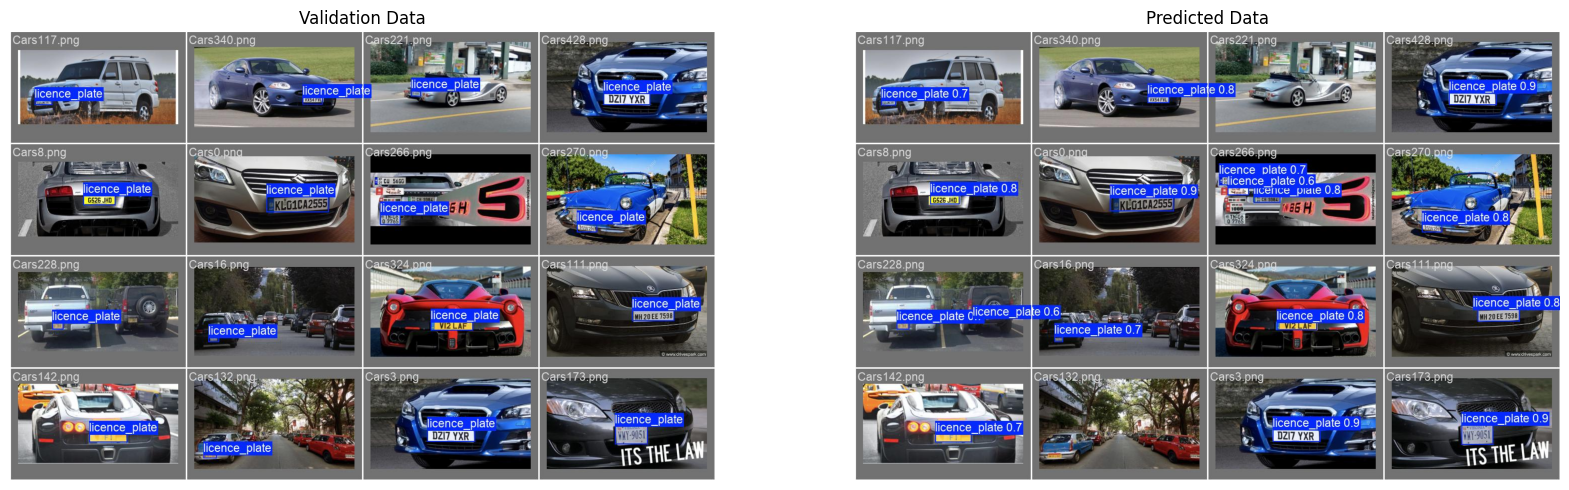

In [ ]:
# === STEP4: PREDICT WITH THE MODEL ==============================================
# === COMPARE THE MODEL WITH VALIDATION DATA AND PREDICT THE RESULT ==============
# After training the model, we can compare the model prediction with the validation data to check the model accuracy.
# Predicted Data: is the result of the model after training (PREDICT WITH PERCENTAGE)
# Validation Data: is data to check the model accuracy (THE TRUTH)

# load the image and show the result
img_valid = cv2.imread('data/yolo_car_plate_convert/runs/val/license_plate_validation/val_batch0_labels.jpg')
img_result = cv2.imread('data/yolo_car_plate_convert/runs/val/license_plate_validation/val_batch0_pred.jpg')
# convert BGR to RGB
img_valid = cv2.cvtColor(img_valid, cv2.COLOR_BGR2RGB)
img_result = cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB)
# show images
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(img_valid)
plt.axis("off")
plt.title("Validation Data")
plt.subplot(1, 2, 2)
plt.imshow(img_result)
plt.axis("off")
plt.title("Predicted Data")
plt.show()



***

## Part 2: Predict new data and plate to predict_car_license_plate/output

This stage is to predict the license plate from the car image using the trained YOLO model. 
The following steps will be performed:
1. Load the trained YOLO model
2. For each image, Predict the license plates using the YOLO model with a confidence threshold
3. Draw bounding boxes on the images and display them

Processing: 98fc39c0-20230105_082641.jpg

0: 224x320 1 licence_plate, 14.3ms
Speed: 0.5ms preprocess, 14.3ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 320)
Saved cropped license plate to: D:\Seneca\CVI\WS\Final_project\Preprocessing\data\predict_car_license_plate\output\d122f14c-33aa-4b26-9930-71ad19b6498c.jpg


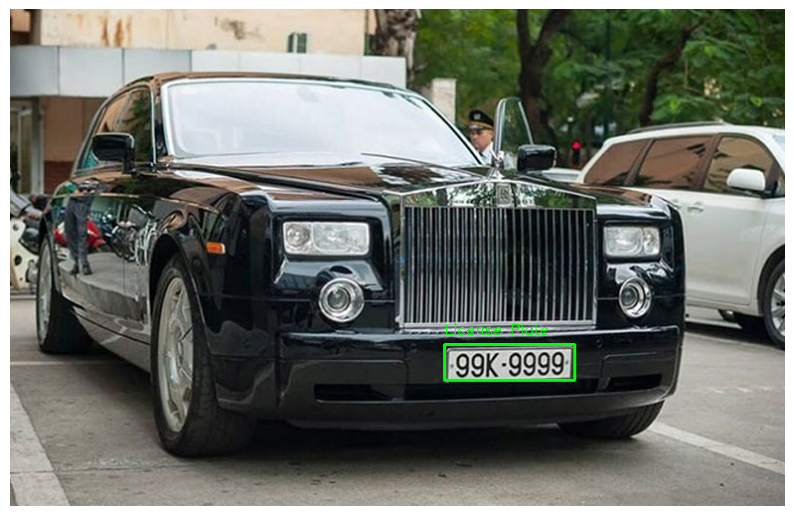

Processing: images (1).jpeg

0: 224x320 1 licence_plate, 11.2ms
Speed: 2.2ms preprocess, 11.2ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)
Saved cropped license plate to: D:\Seneca\CVI\WS\Final_project\Preprocessing\data\predict_car_license_plate\output\a34f9c4d-eff9-4515-acd2-45e16bd1e992.jpg


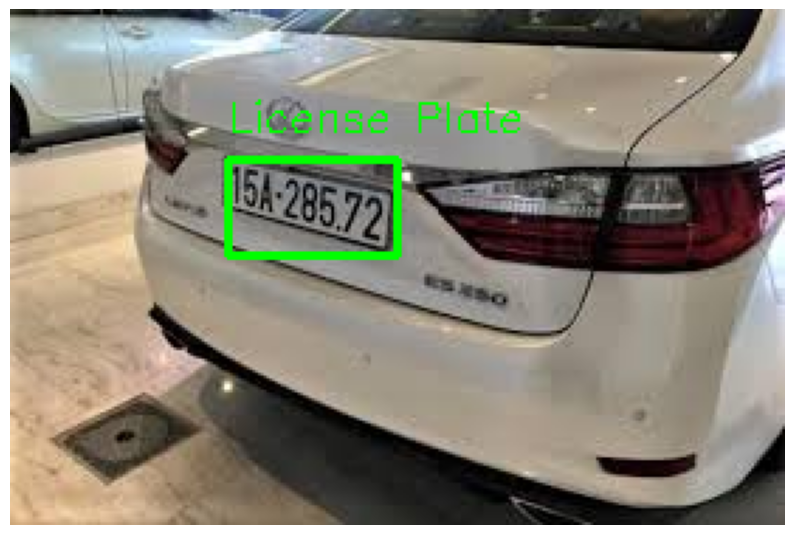

Processing: images (2).jpeg

0: 256x320 1 licence_plate, 15.8ms
Speed: 1.0ms preprocess, 15.8ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
Saved cropped license plate to: D:\Seneca\CVI\WS\Final_project\Preprocessing\data\predict_car_license_plate\output\aa716e1f-181a-4331-8a29-87d026f13910.jpg


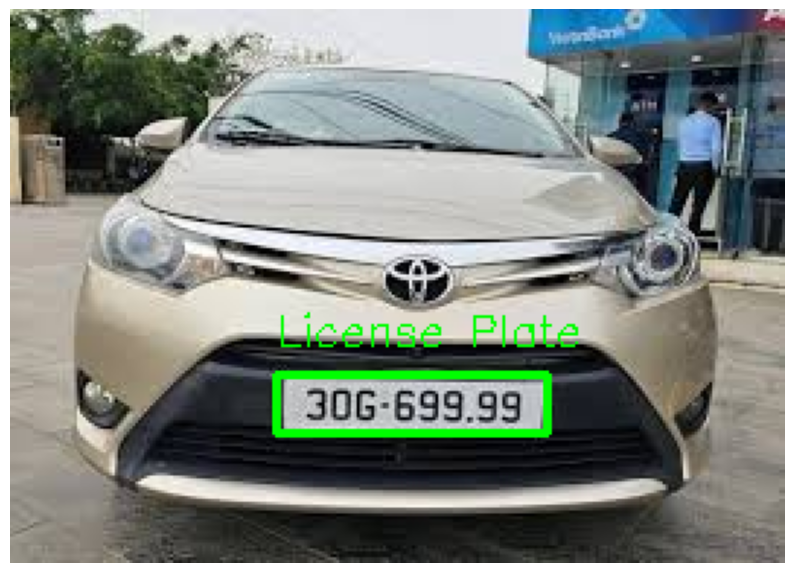

Processing: images.jpeg

0: 256x320 1 licence_plate, 11.7ms
Speed: 1.0ms preprocess, 11.7ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 320)
Saved cropped license plate to: D:\Seneca\CVI\WS\Final_project\Preprocessing\data\predict_car_license_plate\output\a60e68b6-9d4a-4ebb-a890-b6933638b0da.jpg


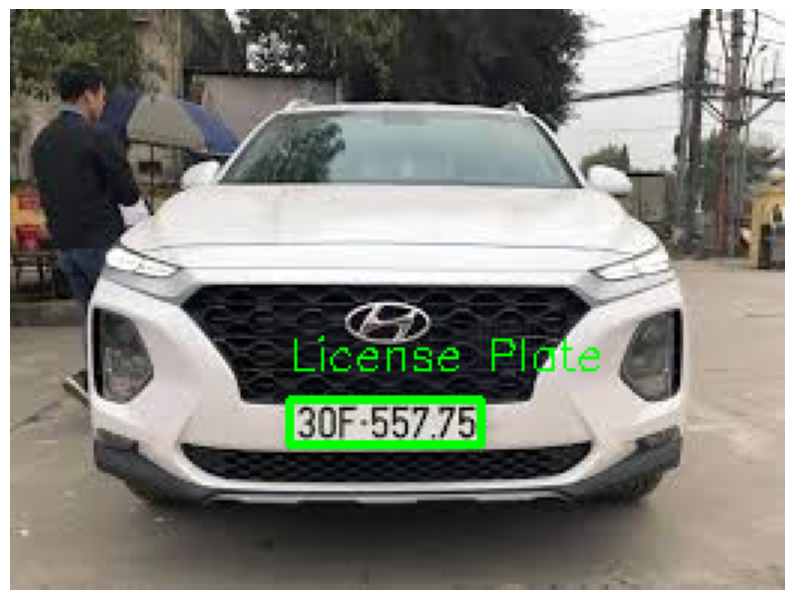

In [28]:
# Function to CROP LICENSE PLATE from the image
def cut_license_plate(image, bbox):
    """
    Crops the license plate from the image based on the bounding box coordinates.
    :param image: Original image (numpy array)
    :param bbox: Bounding box in [x_min, y_min, x_max, y_max] format
    :return: Cropped image (PIL Image)
    """
    x_min, y_min, x_max, y_max = map(int, bbox)
    cropped = image[y_min:y_max, x_min:x_max]  # Crop the image
    return Image.fromarray(cropped)  # Convert to PIL Image

# Function to save the cropped image with a unique name
def save_image_with_uuid(image, output_dir):
    """
    Saves the image with a unique filename in the specified directory.
    :param image: PIL Image to save
    :param output_dir: Directory where the image will be saved
    """
    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists
    random_name = f"{uuid.uuid4()}.jpg"  # Generate a random unique name
    save_path = os.path.join(output_dir, random_name)
    image.save(save_path, format='JPEG')  # Save the image
    print(f"Saved cropped license plate to: {save_path}")

#=== LOAD TRAINED YOLO MODEL (after training in previous step) ====================
model = YOLO('data/yolo_car_plate_convert/runs/train/license_plate/weights/best.pt')

# Directory containing input images
input_dir = r"D:\Seneca\CVI\WS\Final_project\Preprocessing\data\predict_car_license_plate\input"

# Directory to save cropped plates
output_dir = r"D:\Seneca\CVI\WS\Final_project\Preprocessing\data\predict_car_license_plate\output"

# Ensure the output directory exists
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)  # Delete existing directory
os.makedirs(output_dir, exist_ok=True)

#=== PREDICT LICENSE PLATE USING YOLO MODEL =======================================
# Iterate over files in the input directory
for file in os.listdir(input_dir):
    # Construct the full path to the image file
    file_path = os.path.join(input_dir, file)
    
    # Skip non-image files
    if not file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
        print(f"Skipping non-image file: {file}")
        continue
    
    # Load the image using OpenCV
    image = cv2.imread(file_path)
    if image is None:
        print(f"Failed to load image: {file}")
        continue

    print(f"Processing: {file}")
    
    #=== PREDICT LICENSE PLATE USING YOLO MODEL with a confidence threshold 0.6 =====
    predictions = model.predict(image, device=0, conf=0.6)  # Add conf=0.6 for thresholding
    
    #=== DRAW BOUNDING BOX on first image with confidence score above threshold 0.6 ===
    # Iterate over the predictions
    for result in predictions:
        for box in result.boxes:
            # Check confidence score before cropping
            if box.conf[0] >= 0.6:  # Ensure confidence is above the threshold
                # Draw the bounding box on the image
                x_min, y_min, x_max, y_max = map(int, box.xyxy[0])
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                
                # put Text on the image
                cv2.putText(image, 'License Plate', (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    # convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Display the image with bounding box using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()
                
                
